In [1]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path

DATA = Path("/content/drive/My Drive/EECS 6893/Project/data")

In [3]:
import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from datetime import datetime

In [4]:
all_file = "train.csv"
train_all = pd.read_csv(DATA / all_file)

In [5]:
train_all.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
train_bit = train_all[train_all["Asset_ID"]==1].set_index("timestamp")
train_eth = train_all[train_all["Asset_ID"]==6].set_index("timestamp")
train_btc = train_all[train_all["Asset_ID"]==2].set_index("timestamp")
train_bnc = train_all[train_all["Asset_ID"]==0].set_index("timestamp")
train_eos = train_all[train_all["Asset_ID"]==5].set_index("timestamp")
train_ethc = train_all[train_all["Asset_ID"]==7].set_index("timestamp")
train_ltc = train_all[train_all["Asset_ID"]==9].set_index("timestamp")
train_mon = train_all[train_all["Asset_ID"]==11].set_index("timestamp")
train_tron = train_all[train_all["Asset_ID"]==13].set_index("timestamp")
train_ste = train_all[train_all["Asset_ID"]==12].set_index("timestamp")
train_car = train_all[train_all["Asset_ID"]==3].set_index("timestamp")
train_iota = train_all[train_all["Asset_ID"]==8].set_index("timestamp")
train_maker = train_all[train_all["Asset_ID"]==10].set_index("timestamp")
train_doge = train_all[train_all["Asset_ID"]==4].set_index("timestamp")

In [7]:
train_eth = train_eth.reindex(range(train_eth.index[0],train_eth.index[-1]+60,60),method='pad')
train_bit = train_bit.reindex(range(train_bit.index[0],train_bit.index[-1]+60,60),method='pad')

In [8]:
train_bit.shape

(1956960, 9)

In [9]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
btc_mini_2021 = train_bit.loc[totimestamp('01/01/2021'):totimestamp('01/02/2021')]
eth_mini_2021 = train_eth.loc[totimestamp('01/01/2021'):totimestamp('01/02/2021')]

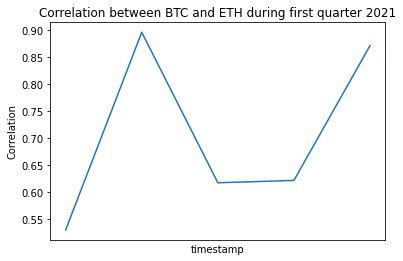

In [10]:
lret_btc_long = btc_mini_2021.Close
lret_eth_long = eth_mini_2021.Close
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]
corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH during first quarter 2021");

In [11]:
two_assets.head()

,lret_btc,lret_eth
timestamp,,
1609459200,28948.192734,736.714286
1609459260,29032.387500,739.341429
1609459320,29002.956734,738.344286
1609459380,29005.580000,737.970515
1609459440,29000.490000,737.477143


In [12]:
asset_file = "asset_details.csv"
asset_details = pd.read_csv(DATA / asset_file)

In [13]:
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = train_all[train_all["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/04/2021'):totimestamp('01/07/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = asset.Close.fillna(0)
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

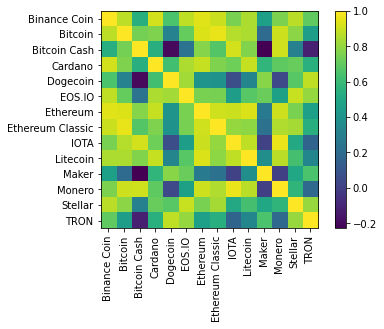

In [14]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

In [15]:
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = train_all[train_all["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/04/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = asset.Close.fillna(0)
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

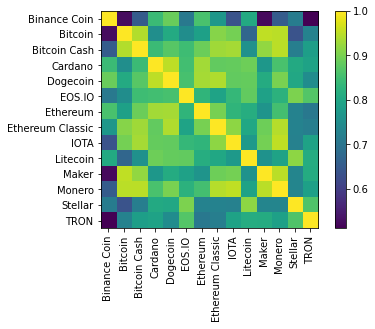

In [16]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

In [17]:
from statsmodels.tsa.stattools import adfuller
# Copied and edited from https://machinelearningmastery.com/time-series-data-stationary-python/
def check_stationarity(series):
  
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
for i, asset_id in enumerate(asset_details.Asset_ID):    
    print(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    asset = train_all[train_all["Asset_ID"]==asset_id].set_index("timestamp")
    asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/04/2021')]
    asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
    lret = asset.Close.fillna(0)
    check_stationarity(lret)
    print('\n')

Bitcoin Cash
ADF Statistic: -2.500589
p-value: 0.115331
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Binance Coin
ADF Statistic: -0.505507
p-value: 0.890937
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Bitcoin
ADF Statistic: -1.318928
p-value: 0.620469
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


EOS.IO
ADF Statistic: -1.595870
p-value: 0.485668
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Ethereum Classic
ADF Statistic: -1.611933
p-value: 0.476961
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Ethereum
ADF Statistic: -2.421651
p-value: 0.135719
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Litecoin
ADF Statistic: -2.152852
p-value: 0.223800
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


Monero
ADF Statistic: -1.237668
p-value: 0.657186
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Non-stationary


TRON


In [ ]:

for i, asset_id in enumerate(asset_details.Asset_ID):    
    print(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    asset = train_all[train_all["Asset_ID"]==asset_id].set_index("timestamp")
    asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/04/2021')]
    asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
    lret = log_return(asset.Close.fillna(0))[1:]
    check_stationarity(lret)
    print('\n')

Bitcoin Cash
ADF Statistic: -43.637082
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Binance Coin
ADF Statistic: -43.359217
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Bitcoin
ADF Statistic: -45.158138
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


EOS.IO
ADF Statistic: -63.190380
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Ethereum Classic
ADF Statistic: -45.837544
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Ethereum
ADF Statistic: -44.260201
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Litecoin
ADF Statistic: -46.488861
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


Monero
ADF Statistic: -78.235401
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


TRON
ADF Statistic: -43.61457

In [19]:
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

In [40]:
bit_file = "train_bitcoin.csv"
train_bit = pd.read_csv(DATA / bit_file)

In [41]:
train_bit.columns

Index(['Unnamed: 0', 'timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target'],
      dtype='object')

In [42]:
train_bit.timestamp[1]

1514764920

In [27]:
train_bit['timestamp'] = pd.to_datetime(train_bit['timestamp'], unit='s')

In [28]:
train_bit['timestamp'] = pd.to_datetime(train_bit['timestamp']).dt.to_period('D')

In [29]:
train_bit.head()

,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2,2018-01-01,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1,10,2018-01-01,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2,18,2018-01-01,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
3,26,2018-01-01,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
4,34,2018-01-01,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [30]:
print(f'Number of rows present in the bitcoin data is {len(train_bit)}')

Number of rows present in the bitcoin data is 1956282


In [31]:
train_bit.Asset_ID.unique()

array([1])

In [32]:
print(f'The training data is available from \
      {str(train_bit.iloc[0].timestamp.day) + "-" + str(train_bit.iloc[0].timestamp.month) + "-" + str(train_bit.iloc[0].timestamp.year)} to \
      {str(train_bit.iloc[-1].timestamp.day) + "-" + str(train_bit.iloc[-1].timestamp.month) + "-" + str(train_bit.iloc[-1].timestamp.year)} \
      for {len(train_bit.groupby("timestamp"))} days')

The training data is available from       1-1-2018 to       21-9-2021       for 1360 days


In [33]:
train_bit.head(5)

,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,2,2018-01-01,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1,10,2018-01-01,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2,18,2018-01-01,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
3,26,2018-01-01,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
4,34,2018-01-01,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [43]:
import plotly.graph_objects as go

In [ ]:
bit_file = "train_bitcoin.csv"
train_bit = pd.read_csv(DATA / bit_file)

In [44]:
del train_bit['Unnamed: 0']

In [45]:
train_bit.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target'],
      dtype='object')

In [46]:
bit = train_bit.set_index('timestamp')

In [47]:
bit_rec = bit[-100:]

In [48]:
fig = go.Figure(data=[go.Candlestick(x=bit_rec.index, open=bit_rec['Open'], high=bit_rec['High'], low=bit_rec['Low'], close=bit_rec['Close'])])
fig.show()

In [50]:
bit.info

<bound method DataFrame.info of             Asset_ID   Count          Open  ...      Volume          VWAP    Target
timestamp                                   ...                                    
1514764860         1   229.0  13835.194000  ...   31.550062  13827.062093 -0.014643
1514764920         1   235.0  13835.036000  ...   31.046432  13840.362591 -0.015037
1514764980         1   528.0  13823.900000  ...   55.061820  13806.068014 -0.010309
1514765040         1   435.0  13802.512000  ...   38.780529  13783.598101 -0.008999
1514765100         1   742.0  13766.000000  ...  108.501637  13735.586842 -0.008079
...              ...     ...           ...  ...         ...           ...       ...
1632182160         1  1940.0  42983.780000  ...   56.850913  42935.489499       NaN
1632182220         1  2026.0  42904.197143  ...   80.993326  42879.576084       NaN
1632182280         1  1986.0  42859.385714  ...   65.677734  42844.090693       NaN
1632182340         1  4047.0  42839.012802  

In [51]:
bit.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

In [52]:
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')

In [53]:
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [54]:
import matplotlib.pyplot as plt

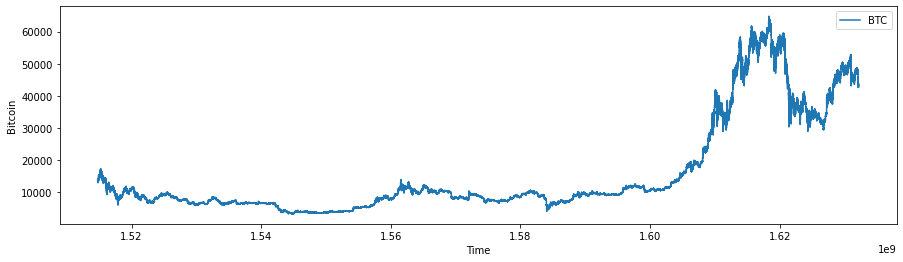

In [55]:
f = plt.figure(figsize=(15,4))

plt.plot(bit['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

plt.show()

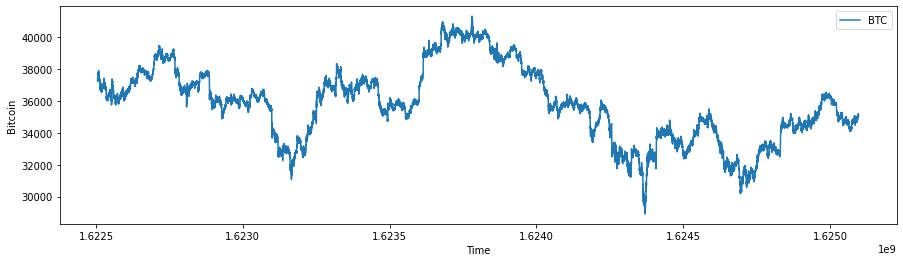

In [56]:
import time

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
bit_rec = bit.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

f = plt.figure(figsize=(15,4))

plt.plot(bit_rec['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

plt.show()

In [57]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

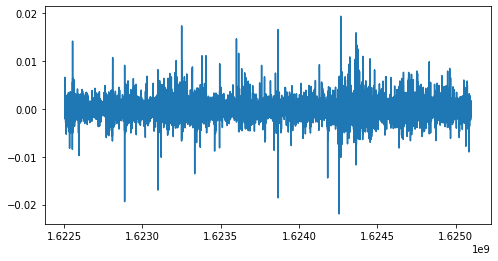

In [58]:
import scipy.stats as stats

lret_btc = log_return(bit_rec.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_btc);
plt.show()

In [83]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low
X_btc = pd.concat([log_return(bit.VWAP,periods=5), log_return(bit.VWAP,periods=1).abs(), 
               upper_shadow(bit), lower_shadow(bit)], axis=1)
y_btc = bit.Target

In [84]:
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [85]:
X_btc = pd.concat([bit.Open,bit.Count,bit.High,bit.Low,bit.Close], axis=1)
y_btc = bit.Close
train_window = [totimestamp("01/05/2021"), totimestamp("06/05/2021")]
test_window = [totimestamp("07/05/2021"), totimestamp("08/05/2021")]
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [62]:
X_btc.head()

,Open,Count,High,Low,Close
timestamp,,,,,
1514764860,13835.194,229.0,14013.8,13666.11,13850.176
1514764920,13835.036,235.0,14052.3,13680.00,13828.102
1514764980,13823.900,528.0,14000.4,13601.00,13801.314
1514765040,13802.512,435.0,13999.0,13576.28,13768.040
1514765100,13766.000,742.0,13955.9,13554.44,13724.914


In [86]:
y_btc.head()

timestamp
1514764860    13850.176
1514764920    13828.102
1514764980    13801.314
1514765040    13768.040
1514765100    13724.914
Name: Close, dtype: float64

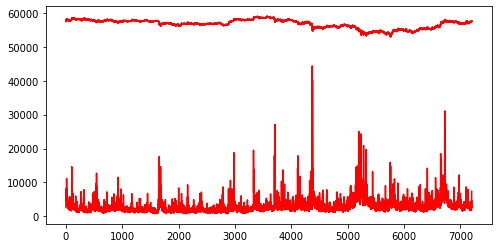

In [87]:
plt.figure(figsize=(8,4))
plt.plot(y_btc_train,color='blue');
plt.plot(X_btc_train,color='red');
plt.show()

In [88]:
X_btc_train.shape

(7201, 5)

In [89]:
#X_btc_train = X_btc_train.reshape(-1,1)
#X_btc_test = X_btc_test.reshape(-1,1)
y_btc_train = y_btc_train.reshape(-1,1)
y_btc_test = y_btc_test.reshape(-1,1)

In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.fit_transform(X_btc_test)
y_btc_train_scaled = scaler.fit_transform(y_btc_train)
y_btc_test_scaled = scaler.fit_transform(y_btc_test)

In [91]:
from itertools import chain

In [92]:
X_train = []
y_train = []
X_test = []
y_test = []
length = 60
for i in range(len(X_btc_train_scaled)-length):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_train_scaled[i+j]))
    X_train.append(temp)
    y_train.append(y_btc_train_scaled[i+length])
    
for i in range(len(X_btc_test_scaled)-length):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_test_scaled[i+j]))
    X_test.append(temp)
    y_test.append(y_btc_test_scaled[i+length])

In [99]:
X_btc_train_scaled = np.array(X_train)
y_btc_train_scaled = np.array(y_train)
X_btc_test_scaled = np.array(X_test)
y_btc_test_scaled = np.array(y_test)

In [100]:
X_btc_train_scaled = X_btc_train_scaled.reshape(len(X_btc_train_scaled),300)

In [101]:
X_btc_test_scaled = X_btc_test_scaled.reshape(len(X_btc_test_scaled),300)

In [102]:
print(X_btc_train_scaled.shape,y_btc_train_scaled.shape,X_btc_test_scaled.shape,y_btc_test_scaled.shape)

(7141, 300) (7141, 1) (1381, 300) (1381, 1)


In [103]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train_scaled)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

In [ ]:
y_pred_lr_btc

array([[0.7907962 ],
       [0.7899882 ],
       [0.7897108 ],
       ...,
       [0.42096382],
       [0.42345983],
       [0.42565274]], dtype=float32)

In [ ]:
y_btc_test_scaled

array([[0.95907454],
       [0.95826653],
       [0.95798929],
       ...,
       [0.53080602],
       [0.53378622],
       [0.5364118 ]])

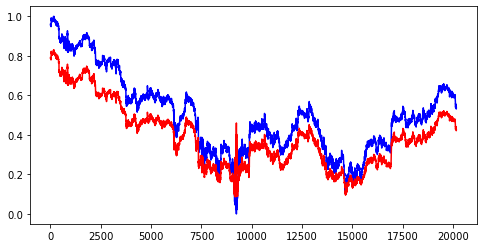

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue');
plt.plot(y_pred_lr_btc,color='red');
plt.show()

In [ ]:
np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]

-0.01071237291070756

In [ ]:
X_btc_train_scaled = X_btc_train_scaled.reshape(X_btc_train_scaled.shape[0],1,X_btc_train_scaled.shape[1])
X_btc_test_scaled = X_btc_test_scaled.reshape(X_btc_test_scaled.shape[0],1,X_btc_test_scaled.shape[1])

In [ ]:
print(X_btc_train_scaled.shape, y_btc_train_scaled.shape,X_btc_test_scaled.shape, y_btc_test_scaled.shape)

(7141, 60, 5) (7141, 1) (1381, 60, 5) (1381, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(60,5), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            4864      
                                                                 
 lstm_1 (LSTM)               (None, 60, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,537
Trainable params: 21,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_btc_train_scaled, y_btc_train_scaled, epochs=5, batch_size=32)

Epoch 1/5
224/224 [==============================] - 19s 54ms/step - loss: 0.0480
Epoch 2/5
224/224 [==============================] - 12s 54ms/step - loss: 0.0025
Epoch 3/5
224/224 [==============================] - 12s 54ms/step - loss: 0.0021
Epoch 4/5
224/224 [==============================] - 12s 55ms/step - loss: 0.0019
Epoch 5/5
224/224 [==============================] - 12s 55ms/step - loss: 0.0018


In [ ]:
y_pred_lr_btc = model.predict(X_btc_test_scaled)

In [ ]:
y_pred_lr_btc.shape

(1381, 1)

In [ ]:
np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]

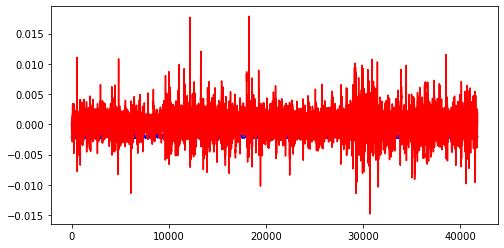

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(10*y_pred_lr_btc[:,0],color = 'blue',label = 'pred');
plt.plot(y_btc_test,color = 'red',label = 'real');
plt.show()

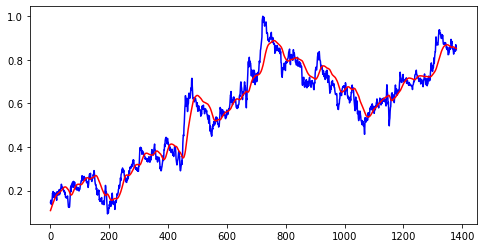

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue');
plt.plot(y_pred_lr_btc,color='red');
plt.show()

In [ ]:
accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(y_btc_test_scaled, y_pred_lr_btc).numpy()))
print(accuracy)

91.37315464019775


In [ ]:
# Lets try predciting price after 15mins

X_btc = pd.concat([bit.Open,bit.Count,bit.High,bit.Low,bit.Close], axis=1)
y_btc = bit.Close
train_window = [totimestamp("01/05/2021"), totimestamp("06/05/2021")]
test_window = [totimestamp("07/05/2021"), totimestamp("08/05/2021")]
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [ ]:
y_btc_train = y_btc_train.reshape(-1,1)
y_btc_test = y_btc_test.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.fit_transform(X_btc_test)
y_btc_train_scaled = scaler.fit_transform(y_btc_train)
y_btc_test_scaled = scaler.fit_transform(y_btc_test)

In [ ]:
from itertools import chain
X_train = []
y_train = []
X_test = []
y_test = []
length = 60
duration = 90 #Add 15min gap between features and target
for i in range(len(X_btc_train_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_train_scaled[i+j]))
    X_train.append(temp)
    y_train.append(y_btc_train_scaled[i+length+duration])
    
for i in range(len(X_btc_test_scaled)-length-duration):
    temp = []
    for j in range(length):
        temp = list(chain(temp,X_btc_test_scaled[i+j]))
    X_test.append(temp)
    y_test.append(y_btc_test_scaled[i+length+duration])

In [ ]:
X_btc_train_scaled = np.array(X_train)
y_btc_train_scaled = np.array(y_train)
X_btc_test_scaled = np.array(X_test)
y_btc_test_scaled = np.array(y_test)
X_btc_train_scaled = X_btc_train_scaled.reshape(len(X_btc_train_scaled),60,5)
X_btc_test_scaled = X_btc_test_scaled.reshape(len(X_btc_test_scaled),60,5)
print(X_btc_train_scaled.shape,y_btc_train_scaled.shape,X_btc_test_scaled.shape,y_btc_test_scaled.shape)

(7051, 60, 5) (7051, 1) (1291, 60, 5) (1291, 1)


In [ ]:
model.fit(X_btc_train_scaled, y_btc_train_scaled, epochs=5, batch_size=32)

Epoch 1/5
221/221 [==============================] - 19s 84ms/step - loss: 0.0073
Epoch 2/5
221/221 [==============================] - 17s 79ms/step - loss: 0.0071
Epoch 3/5
221/221 [==============================] - 18s 80ms/step - loss: 0.0072
Epoch 4/5
221/221 [==============================] - 17s 79ms/step - loss: 0.0071
Epoch 5/5
221/221 [==============================] - 17s 78ms/step - loss: 0.0069


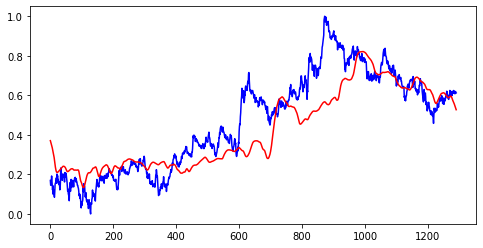

In [ ]:
y_pred_lr_btc = model.predict(X_btc_test_scaled)
plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue');
plt.plot(y_pred_lr_btc,color='red');
plt.show()

In [ ]:
accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(np.maximum(y_btc_test_scaled,1e-3), y_pred_lr_btc).numpy()))
print(accuracy)

51.15089797973633


In [ ]:
X_btc_train_scaled = np.array(X_train)
y_btc_train_scaled = np.array(y_train)
X_btc_test_scaled = np.array(X_test)
y_btc_test_scaled = np.array(y_test)
print(X_btc_train_scaled.shape,y_btc_train_scaled.shape,X_btc_test_scaled.shape,y_btc_test_scaled.shape)

(7051, 300) (7051, 1) (1291, 300) (1291, 1)


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train_scaled)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

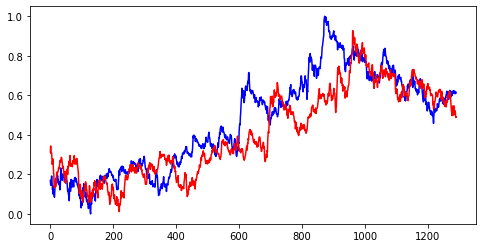

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_btc_test_scaled,color='blue');
plt.plot(y_pred_lr_btc,color='red');
plt.show()

In [ ]:
accuracy = (100-np.average(tf.keras.metrics.mean_absolute_percentage_error(y_btc_test_scaled+1e-3, y_pred_lr_btc).numpy()))
print(accuracy)

64.04466069034892
